<a href="https://colab.research.google.com/github/mon-neutrino/ml-stuff/blob/main/mon_Working_Lung_Cancer_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

try:
    %tensorflow_version 2.x
except:
    pass
    
import numpy as np

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.2.0


Using TensorFlow backend.


In [ ]:
# Setup Kaggle Connection
! pip install -q kaggle
! pip install git+https://github.com/mjkvaak/ImageDataAugmentor
# Get kaggle.json from here https://www.kaggle.com/<username>/account

In [ ]:
! pip install albumentations

In [ ]:
import albumentations

In [ ]:
# Uplaod the kaggle.json here.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"monicasing","key":"113f0b4f04f3543a4b17163494c71a93"}'}

In [ ]:
# Make Kaggle Folder
# ! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

to look for kaggle data set, type following. after -s is the dataset u want

In [ ]:
# Search Kaggle Datasets
! kaggle datasets list -s lung-cancer-detection

In [ ]:
# Download the Lung Cancer CT Dataset
! kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

 99% 1.75G/1.76G [00:19<00:00, 119MB/s]
100% 1.76G/1.76G [00:19<00:00, 97.4MB/s]


In [ ]:
! mkdir training_data
! unzip lung-and-colon-cancer-histopathological-images.zip -d training_data
# unzips thefile, then adds into train directory

In [ ]:
# Generate Paths:
import os

# Generate path from root into lung image folder
trainpath = os.path.dirname('/content/training_data/lung_colon_image_set')
main_path_string = '/content/training_data/lung_colon_image_set/lung_image_sets/'
main_path = os.path.dirname(main_path_string)
#dirname will convert the string into computer readable info

# Generate paths from root into each type of cancer.
lungadenocapath = os.path.join(main_path, 'lung_aca/')
lungnormalpath = os.path.join(main_path, "lung_n/")
lungsquamouscarcinomapath = os.path.join(main_path, 'lung_scc/')

def abs_paths(my_directory):
  """
  Returns all file paths within a directory.
  e.g. abs_paths(lungadenocapath) returns 
  ['/content/training_data/lung_colon_image_set/lung_image_sets/lung_aca/lungaca2579.jpeg', 
  '/content/training_data/lung_colon_image_set/lung_image_sets/lung_aca/lungaca441.jpeg' ... etc]
  """
  file_paths = []
  # file paths is a list, os walk will walk through whatveer directory it is

  for folder, subs, files in os.walk(my_directory):
    for filename in files: # absolute path will return the full path like above
      file_paths.append(os.path.abspath(os.path.join(folder, filename)))

  return file_paths

adenocarc = abs_paths(lungadenocapath)
normal = abs_paths(lungnormalpath)
squamouscarcinoma = abs_paths(lungsquamouscarcinomapath)

In [ ]:
# Generate Dataframes using PANDAS
adeno = list(zip(adenocarc, ['adenocarc']*len(adenocarc)))
adeno_df = pd.DataFrame(adeno, columns=['file', 'label'])
print(adeno_df.head())

norm = list(zip(normal, ['normal']*len(normal)))
normal_df = pd.DataFrame(norm, columns=['file', 'label'])
print(normal_df.head())

squamouscarcinoma=list(zip(squamouscarcinoma, ['squamous']*len(squamouscarcinoma)*2))
squamous_df = pd.DataFrame(squamouscarcinoma, columns=['file', 'label'])
print(squamous_df.head())

In [ ]:
# Combine into one dataframe
dataframe=pd.concat([adeno_df, normal_df, squamous_df])
len(dataframe)

15000

In [ ]:
# Convert to style for data_gen 
# get dummies will basically summarize graph into and categorize into whatever we want
df = pd.get_dummies(dataframe['label'])
# not needed: df=pd.concat([dataframe, df], axis=1)
df=pd.concat([dataframe, df], axis=1)
df.sample(5)

,file,label,adenocarc,normal,squamous
4737,/content/training_data/lung_colon_image_set/lu...,normal,0,1,0
4188,/content/training_data/lung_colon_image_set/lu...,normal,0,1,0
3691,/content/training_data/lung_colon_image_set/lu...,normal,0,1,0
87,/content/training_data/lung_colon_image_set/lu...,squamous,0,0,1
3635,/content/training_data/lung_colon_image_set/lu...,normal,0,1,0


In [ ]:
df.to_csv('lung_df.csv')
files.download('lung_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df = df.sample(frac=1)
df.head()

,file,label,adenocarc,normal,squamous
2519,/content/training_data/lung_colon_image_set/lu...,normal,0,1,0
3010,/content/training_data/lung_colon_image_set/lu...,adenocarc,1,0,0
3882,/content/training_data/lung_colon_image_set/lu...,squamous,0,0,1
1697,/content/training_data/lung_colon_image_set/lu...,squamous,0,0,1
1990,/content/training_data/lung_colon_image_set/lu...,adenocarc,1,0,0


In [ ]:
# Create the generator
from ImageDataAugmentor.image_data_augmentor import *
data_gen= ImageDataAugmentor(rescale = 1/255.)

In [ ]:
# Split into training and test
img_shape = 300
# image shape can take an arbitrary number as long as its rightfuly referenced in generator
batch_size = 100
# batch size is to seperate data set into ittle groups that run parallel to each other
length = len(df)
# What the following is doing is selecting 80% of the data to train, while the rest 20% to test
# hence multiplying by .8
# sometimes it's better to cast that calculation with length*.8 as an int variable just in case
train_df = df.iloc[0:int(length*0.8), :]
test_df = df.iloc[int(length*0.8):int(length), :]
train_generator=data_gen.flow_from_dataframe(train_df,
                                             target_size = (img_shape, img_shape),
                                             x_col = 'file', # soecficy x and y coloumns of dataset
                                             y_col = ['adenocarc', 'normal', 'squamous'],
                                             class_mode = 'raw',
                                             shuffle=True, # shuffling data so its random and better accuracy on network efficiency
                                             batch_size = batch_size)
test_generator=data_gen.flow_from_dataframe(test_df,
                                             target_size = (img_shape, img_shape),
                                             x_col = 'file',
                                             y_col = ['adenocarc', 'normal', 'squamous'],
                                             class_mode = 'raw',
                                           shuffle=False, # shuffling not needed as we r just testing
                                             batch_size = batch_size)

Found 12000 validated image filenames.
Found 3000 validated image filenames.


Found 12000 validated image filenames.


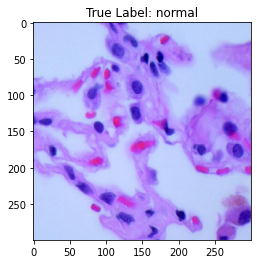

In [ ]:
# Preview the CT Scans
preview_generator=data_gen.flow_from_dataframe(train_df,
                                             target_size = (img_shape, img_shape),
                                             x_col = 'file',
                                             y_col = ['adenocarc', 'normal', 'squamous'],
                                             class_mode = 'raw',
                                             shuffle=True)
# No batch size for easier indexing. Not training with this one.
# Drag the slider to see different previews.

from matplotlib import pyplot as plt
image_num = 10 #@param {type:"slider", min:0, max:30, step:1}

plt.imshow(preview_generator[0][0][image_num], cmap=plt.cm.binary)
plt.title('True Label: {}'.format(['adenocarc', 'normal', 'squamous'][np.argmax(preview_generator[0][1][image_num])], fontdict={'size': 16}))
plt.show()

In [ ]:
# Create a network using the sequential Keras API.

import tensorflow as tf

model = tf.keras.Sequential([tf.keras.layers.Conv2D(input_shape=(img_shape,img_shape,3), filters=4, kernel_size=3),
                             tf.keras.layers.MaxPool2D(4),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(input_shape=(img_shape,img_shape,3), filters=4, kernel_size=3),
                             tf.keras.layers.MaxPool2D(4),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(input_shape=(img_shape,img_shape,3), filters=4, kernel_size=3),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(16, activation=tf.nn.relu),
                             tf.keras.layers.Dense(16, activation=tf.nn.relu),
                             tf.keras.layers.Dense(3, activation=tf.nn.softmax, name='Softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 298, 298, 4)       112       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 4)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 74, 74, 4)         16        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 4)         148       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 18, 18, 4)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 18, 18, 4)         16        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 4)        

In [ ]:
# Standard Model Configuration:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 5

# Train it:
history = model.fit(train_generator,epochs=5,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=test_generator)

# around 80% accuracy

Certainties: [[0.06128404 0.7891756  0.1495403 ]]


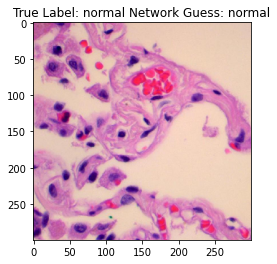

In [ ]:
# Test it: Evaluate the model on the test images.
# Drag the slider to see different previews.

from matplotlib import pyplot as plt
image_num = 24 #@param {type:"slider", min:0, max:30, step:1}

img = preview_generator[0][0][image_num]

img = img.reshape(300, 300, 3)
true_label = ['adenocarc', 'normal', 'squamous'][np.argmax(preview_generator[0][1][image_num])]
print("Certainties: {}".format(model.predict(img.reshape([1, 300, 300, 3]))))
guess = ['adenocarc', 'normal', 'squamous'][np.argmax(model.predict(img.reshape([1, 300, 300, 3])))]

plt.imshow(img , cmap=plt.cm.binary)
plt.title('True Label: {} Network Guess: {}'.format(true_label, guess, fontdict={'size': 16}))
plt.show()
